# An introduction to explainable AI with Shapley values

In [1]:
import pandas as pd
import shap
import sklearn

# a classic housing price dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

1. CRIM - 町ごとの一人当たりの犯罪率
2. ZN - 25,000平方フィート以上の区画に指定されている住宅地の割合
3. INDUS - 町ごとの非小売業の面積の割合。
4. CHAS - チャールズ川のダミー変数（トラクトが川に接している場合は1、そうでない場合は0）。
5. NOX - 一酸化窒素濃度（1000万分の1）。
6. RM - 住居あたりの平均部屋数
7. AGE - 1940年以前に建てられた持ち家の割合
8. DIS - ボストンの5つの雇用中心地までの加重距離
9. RAD - 放射状の高速道路へのアクセス性を示す指標
10. TAX - 10,000ドルあたりの固定資産税の全額負担率
11. PTRATIO - 町ごとの生徒と教師の比率
12. B - 1000(Bk - 0.63)^2 ここで、Bkは町による黒人の割合である。
13. LSTAT - 人口の％低いステータス
14. MEDV - 1000ドル台の持ち家の中央値

In [2]:

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)


LinearRegression()

## 線形回帰
### partial dependence plots
横破線: ボストンの住宅データセットに適用した場合のモデルの期待値  
縦破線: RMの平均値

青線: RMをある値に固定したときのモデルの出力の平均値

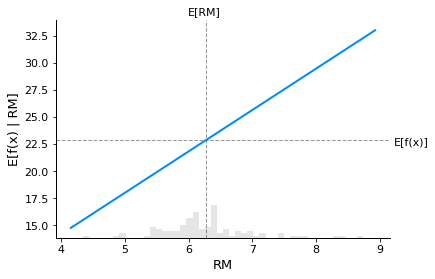

In [3]:
shap.plots.partial_dependence(
    "RM", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

SHAP値はpartial dependependence plotと出力の期待値の差である。  
赤線の長さと向きがRMのSHAP値を表す

Permutation explainer: 507it [00:10,  5.46it/s]


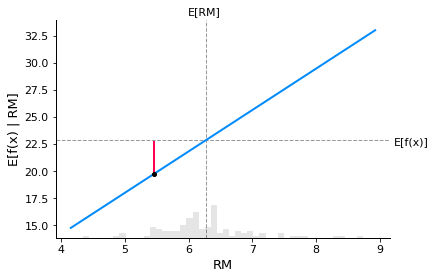

In [4]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "RM", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

SHAP値のプロットはこんな感じになる

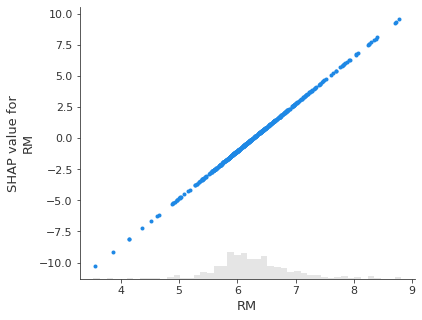

In [5]:
shap.plots.scatter(shap_values[:,"RM"])

`shap_values.base_values`から`model.predict(X)`までの過程を示す

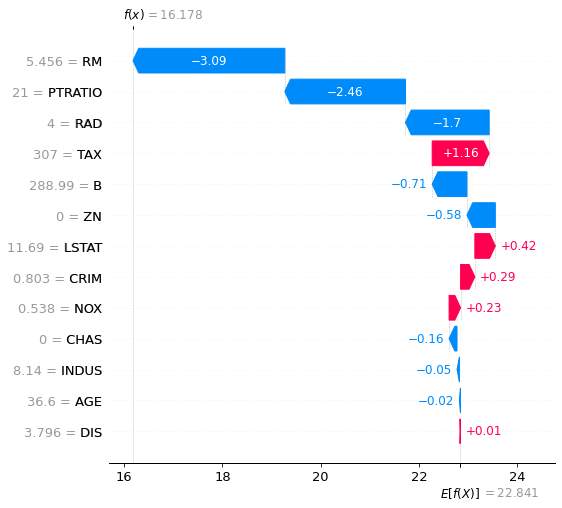

In [6]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

## GAM (Generalized Additive Model)

Permutation explainer: 507it [00:25, 12.06it/s]


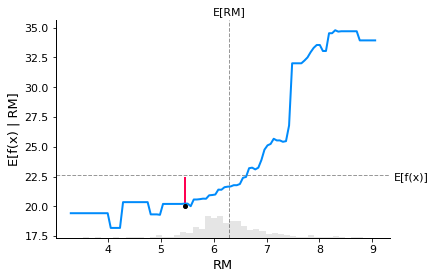

In [7]:
# fit a GAM model to the data
import interpret.glassbox
model_ebm = interpret.glassbox.ExplainableBoostingRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_ebm.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

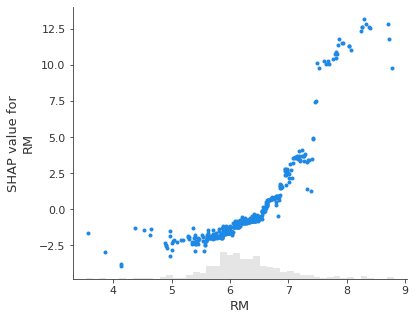

In [8]:
shap.plots.scatter(shap_values_ebm[:,"RM"])

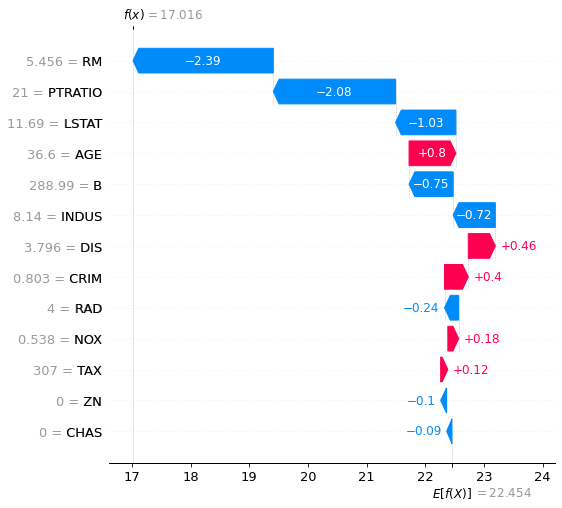

In [9]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind], max_display=14)

全データのSHAP値

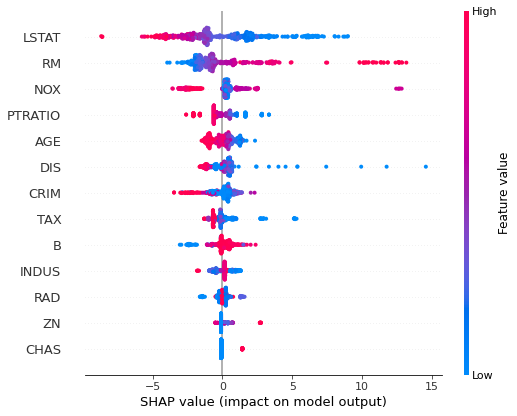

In [10]:
shap.plots.beeswarm(shap_values_ebm, max_display=14)

## XGBoost
non-additive boosted tree model

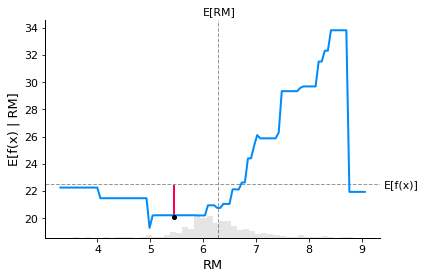

In [11]:
# train XGBoost model
import xgboost
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "RM", model_xgb.predict, X, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_ebm[sample_ind:sample_ind+1,:]
)

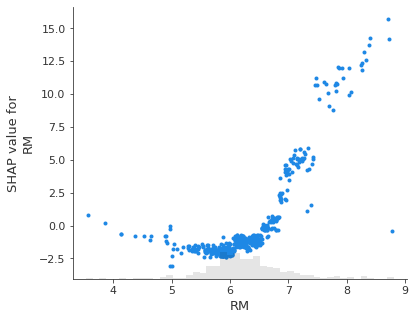

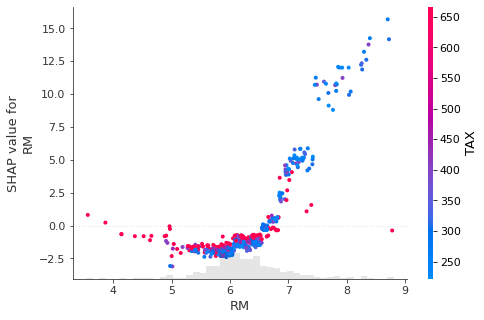

In [12]:
shap.plots.scatter(shap_values_xgb[:,"RM"])
shap.plots.scatter(shap_values_xgb[:,"RM"], color=shap_values)


## ロジスティック回帰

In [13]:
# a classic adult census dataset price dataset
X_adult,y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
    return model_adult.predict_proba(x)[:,1]
def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:,1] - p[:,0]


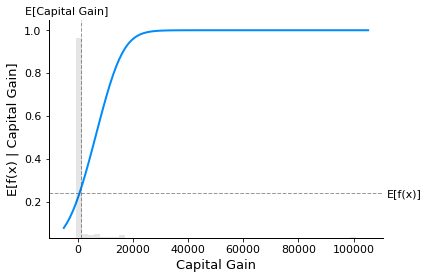

In [14]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
)

In [15]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])

Permutation explainer: 1001it [00:22, 30.88it/s]                         


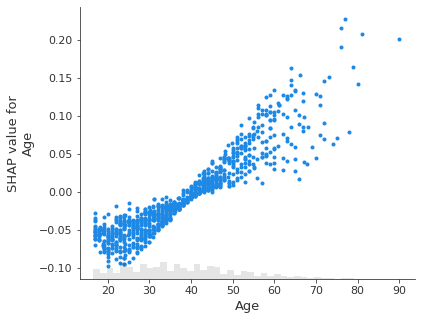

In [16]:
shap.plots.scatter(shap_values_adult[:,"Age"])

対数オッズを出力にすると線形関係が得られる。

In [17]:
# compute the SHAP values for the linear model
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])

Permutation explainer: 1001it [00:17, 24.19it/s]                         


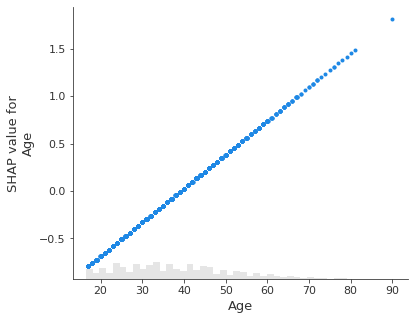

divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log


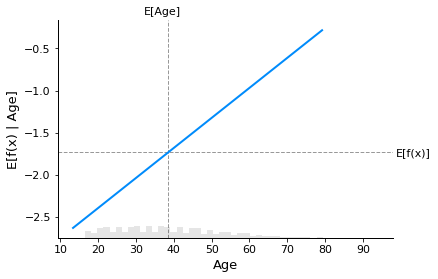

In [18]:
shap.plots.scatter(shap_values_adult_log_odds[:,"Age"])
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Age", model_adult_log_odds, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)


## non-additive boosted tree logistic regression model

In [19]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(X_adult, y_adult)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[19:08:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|===================| 32513/32561 [00:16<00:00]       

デフォルトではSHAP棒グラフは各特徴量ごとにデータセット全体の絶対値の平均が出力される。

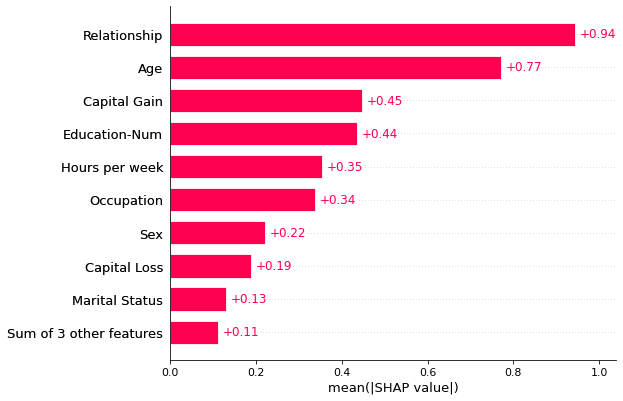

In [20]:
shap.plots.bar(shap_values)

絶対値の最大値でプロットしたらこんな感じ

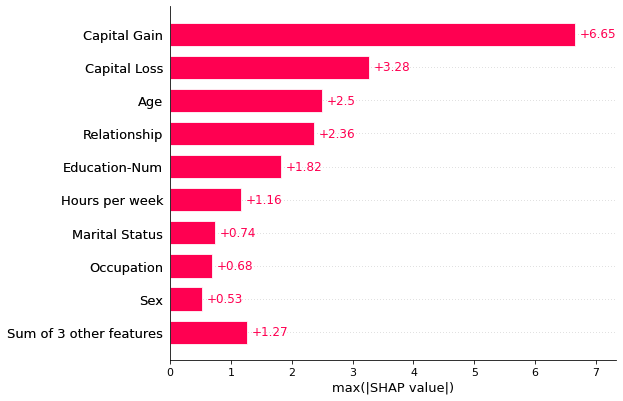

In [21]:
shap.plots.bar(shap_values.abs.max(0))

beeswarm(蜂群図)

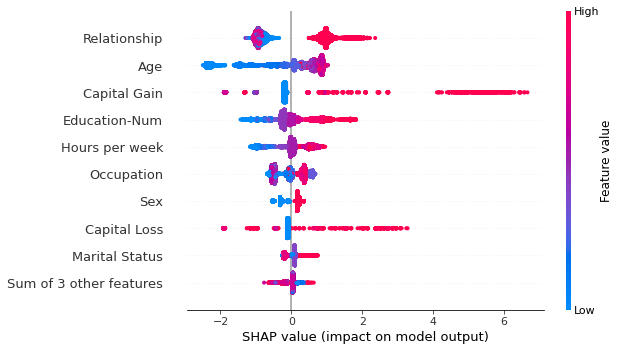

In [22]:
shap.plots.beeswarm(shap_values)

絶対値でbeeswarmを描画し、棒グラフと蜂群図を両立させる。

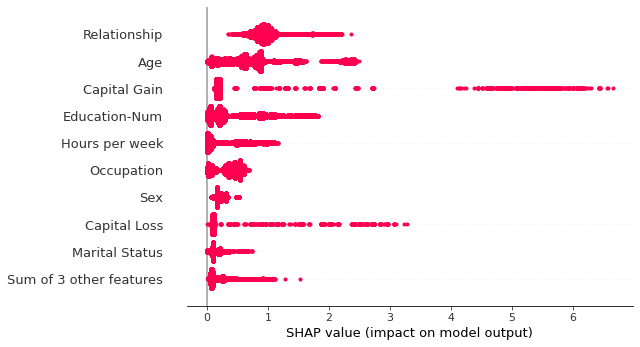

In [23]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

各データのSHAP値のヒートマップ

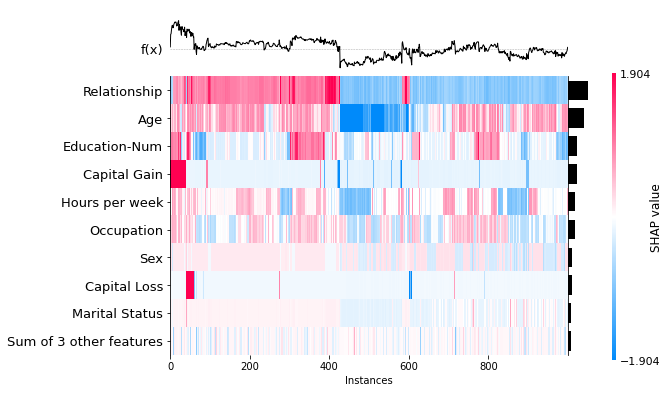

In [24]:
shap.plots.heatmap(shap_values[:1000])

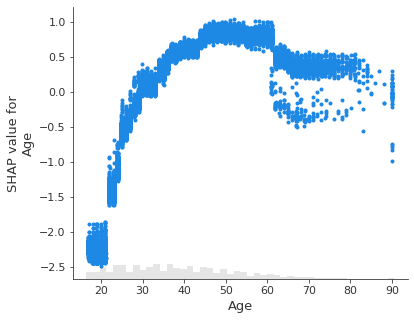

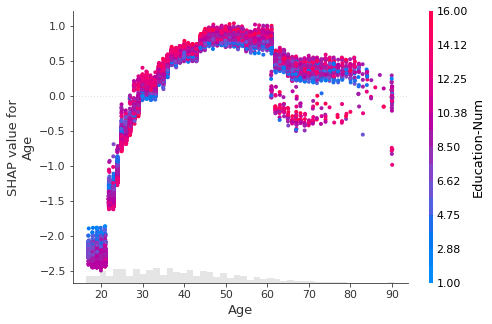

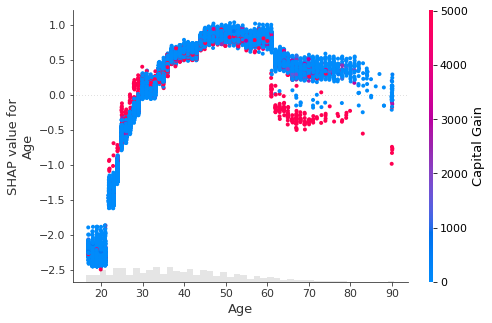

In [27]:
shap.plots.scatter(shap_values[:,"Age"])
shap.plots.scatter(shap_values[:,"Age"], color=shap_values)
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"Capital Gain"])


カテゴリ値だとこんな感じになる

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


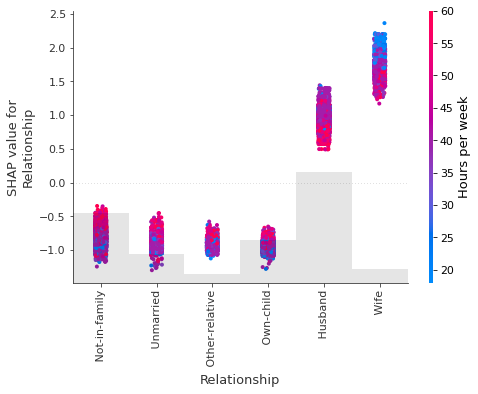

In [28]:
shap.plots.scatter(shap_values[:,"Relationship"], color=shap_values)

## 相関のある特徴量の取り扱い

In [29]:
clustering = shap.utils.hclust(X_adult, y_adult)

クラスタリングして樹形図を描画することができる。

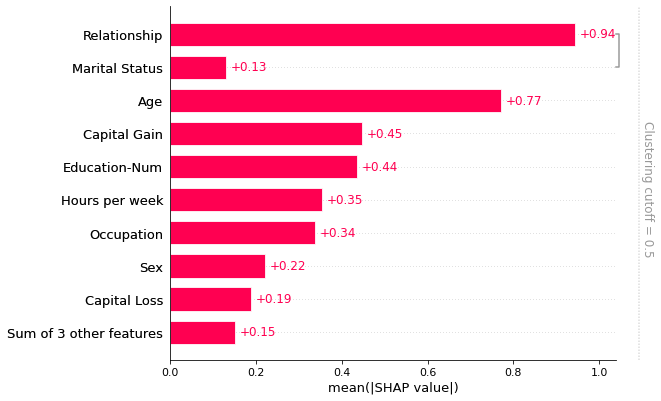

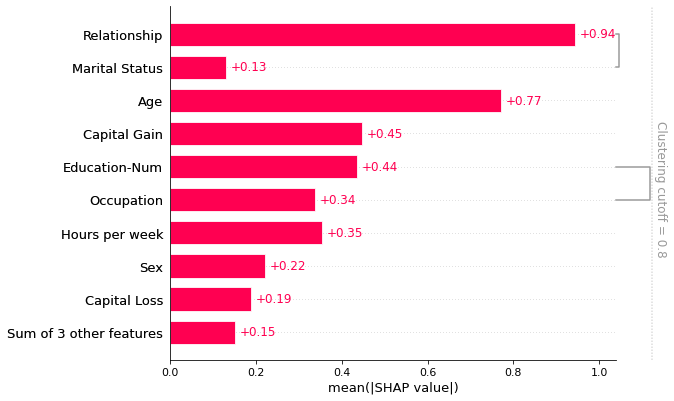

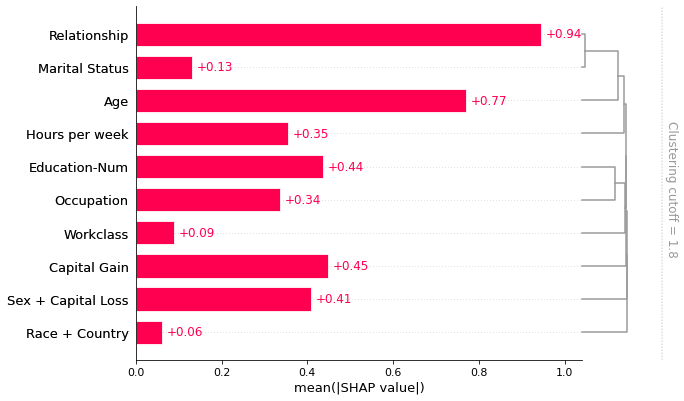

In [31]:
shap.plots.bar(shap_values, clustering=clustering)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=1.8)

## transformers NLPモデル

In [34]:
import transformers
import nlp
import torch
import numpy as np
import scipy as sp

# load a BERT sentiment analysis model
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
model = transformers.DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english"
)

# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=500, truncation=True) for v in x])
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(imdb_train[:10], fixed_context=1)

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors
Partition explainer: 11it [05:46, 34.69s/it]


In [35]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

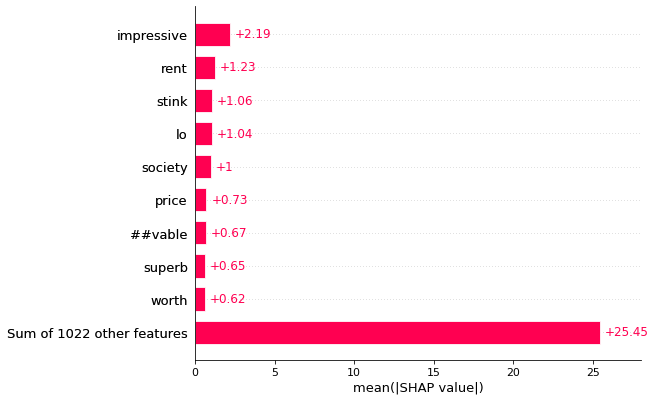

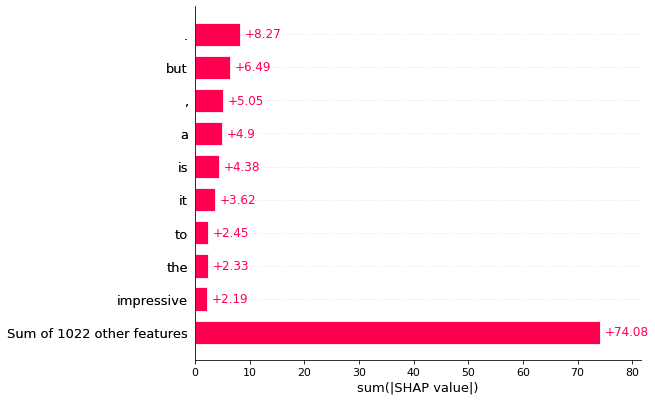

In [36]:
shap.plots.bar(shap_values.abs.mean(0))
shap.plots.bar(shap_values.abs.sum(0))